Paper => https://arxiv.org/abs/1910.02600


In [83]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Deep evidential regression


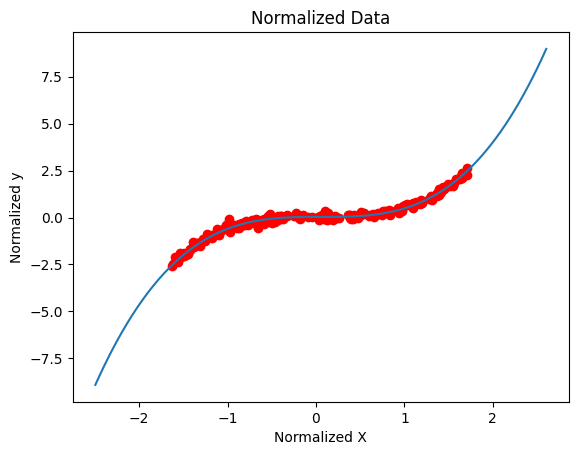

In [62]:
np.random.seed(42)
N = 200

# Generate raw data
X_train_raw = np.random.uniform(-4, 4, N)
eps = np.random.normal(0, 3, N)
y_train_raw = X_train_raw**3 + eps

X_test_raw = np.linspace(-6, 6, 100)
y_test_raw = X_test_raw**3

# Normalize X values
X_mean, X_std = X_train_raw.mean(), X_train_raw.std()
X_train = torch.tensor((X_train_raw - X_mean) / X_std).float()
X_test = torch.tensor((X_test_raw - X_mean) / X_std).float()

# Normalize y values
y_mean, y_std = y_train_raw.mean(), y_train_raw.std()
y_train = torch.tensor((y_train_raw - y_mean) / y_std).float()
y_test = torch.tensor((y_test_raw - y_mean) / y_std).float()

# Plot normalized data
plt.scatter(X_train, y_train, c="r")
plt.plot(X_test, y_test)
plt.xlabel("Normalized X")
plt.ylabel("Normalized y")
plt.title("Normalized Data")
plt.show()

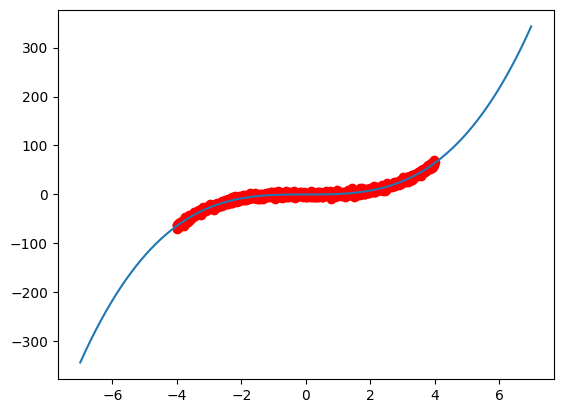

In [81]:
X_train = torch.linspace(-4, 4, 1000).unsqueeze(-1)
sigma = torch.normal(torch.zeros_like(X_train), 3 * torch.ones_like(X_train))
y_train = X_train**3 + sigma

X_test = torch.linspace(-7, 7, 1000).unsqueeze(-1)
y_test = X_test**3

plt.scatter(X_train, y_train, c="r")
plt.plot(X_test, y_test)

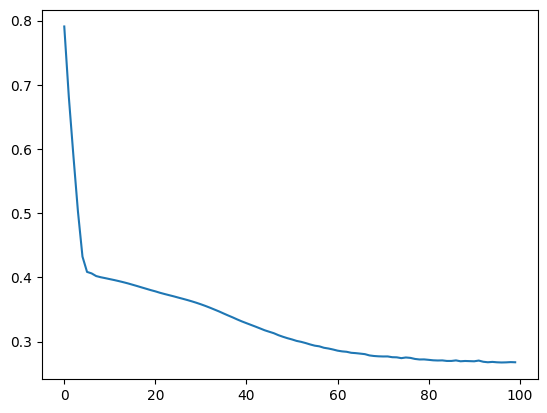

In [111]:
class EvidentialMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
        )
        self.output_layer = nn.Linear(64, 4)

    def forward(self, x):
        out = self.net(x)
        outputs = self.output_layer(out)
        gamma = outputs[:, 0].unsqueeze(1)
        epsilon = F.softplus(outputs[:, 1].unsqueeze(1))
        alpha = F.softplus(outputs[:, 2].unsqueeze(1)) + 1.0
        beta = F.softplus(outputs[:, 3].unsqueeze(1))
        return gamma, epsilon, alpha, beta


def loss_fn(gamma, epsilon, alpha, beta, y_true, lambda_reg=1e-2):
    # Compute NLL loss
    twoBlambda = 2 * beta * (1 + epsilon)
    nll = (
        0.5 * torch.log(np.pi / epsilon)
        - alpha * torch.log(twoBlambda)
        + (alpha + 0.5) * torch.log(epsilon * (y_true - gamma) ** 2 + twoBlambda)
        + torch.lgamma(alpha)
        - torch.lgamma(alpha + 0.5)
    )

    # Compute regularization loss
    reg = torch.abs(y_true - gamma) * (2 * epsilon + alpha)

    # # Combine NLL and regularization losses
    loss = nll + reg * lambda_reg

    # Return mean loss
    return torch.mean(loss)


model = EvidentialMLP()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 100
train_loss = []
for epoch in range(100):
    batch_loss = 0
    for x, y in DataLoader(
        TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True
    ):
        model.train()
        optimizer.zero_grad()
        gamma, epsilon, alpha, beta = model(x)
        loss = loss_fn(gamma, epsilon, alpha, beta, y)
        loss.backward()
        optimizer.step()
        batch_loss += loss.item()
    train_loss.append(batch_loss / batch_size)

plt.plot(train_loss)

In [112]:
def evaluate_model(model, X):
    model.eval()
    with torch.no_grad():
        gamma, epsilon, alpha, beta = model(X)

    # Compute mean prediction
    pred = gamma.squeeze()

    # Compute uncertainties
    aleatoric = (beta / (alpha - 1)).squeeze()
    epistemic = (beta / (epsilon * (alpha - 1))).squeeze()
    total_uncertainty = aleatoric + epistemic

    return pred, aleatoric, epistemic, total_uncertainty


def plot_results(
    X_train, y_train, X_test, y_test, pred, aleatoric, epistemic, total_uncertainty
):
    plt.figure(figsize=(12, 8))

    # Plot training data
    plt.scatter(X_train, y_train, color="blue", alpha=0.5, label="Training data")

    # Plot true function
    plt.plot(X_test, y_test, color="green", label="True function")

    # Plot prediction with uncertainty
    plt.plot(X_test, pred, color="red", label="Prediction")
    plt.fill_between(
        X_test,
        pred - 2 * np.sqrt(total_uncertainty),
        pred + 2 * np.sqrt(total_uncertainty),
        color="red",
        alpha=0.2,
        label="Total uncertainty",
    )

    # Plot aleatoric and epistemic uncertainties
    plt.fill_between(
        X_test,
        pred - 2 * np.sqrt(aleatoric),
        pred + 2 * np.sqrt(aleatoric),
        color="orange",
        alpha=0.2,
        label="Aleatoric uncertainty",
    )
    plt.fill_between(
        X_test,
        pred - 2 * np.sqrt(epistemic),
        pred + 2 * np.sqrt(epistemic),
        color="purple",
        alpha=0.2,
        label="Epistemic uncertainty",
    )

    plt.legend()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Evidential Regression Results")

    # Set y-axis limits to match the extent of y_test
    plt.ylim(y_test.min(), y_test.max())

    plt.show()


# Evaluate the model
model.eval()  # Set the model to evaluation mode
pred, aleatoric, epistemic, total_uncertainty = evaluate_model(model, X_test)


In [113]:
y_train.shape


torch.Size([1000, 1])

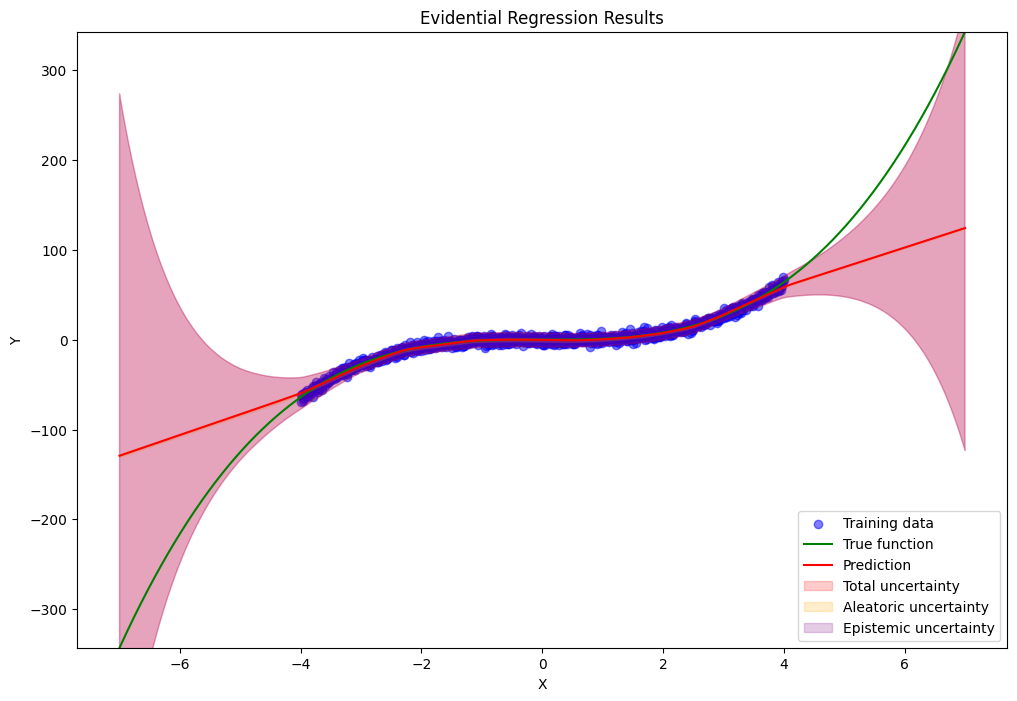

In [115]:
# Convert tensors to numpy for plotting
X_train_np = X_train.squeeze().numpy()
y_train_np = y_train.squeeze().numpy()
X_test_np = X_test.squeeze().numpy()
y_test_np = y_test.squeeze().numpy()
pred_np = pred.numpy()
aleatoric_np = aleatoric.numpy()
epistemic_np = epistemic.numpy()
total_uncertainty_np = total_uncertainty.numpy()

# Plot the results
plot_results(
    X_train_np,
    y_train_np,
    X_test_np,
    y_test_np,
    pred_np,
    aleatoric_np,
    epistemic_np,
    total_uncertainty_np,
)